# EEG DataLoader

The dimensions of the training set are as follows: 4,500 samples, 64 channels, and a time length of 795. This corresponds to 5 categories in y_train.

The dimensions of the testing set are as follows: 750 samples, 64 channels, and a time length of 795. This corresponds to 5 categories in y_test.

You can download it from this Google Drive link: [https://drive.google.com/drive/folders/1ykR-mn4d4KfFeeNrfR6UdtebsNRY8PU2?usp=sharing].
Please download the data and place it in your data_path at "./data."

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchviz import make_dot

In [2]:
data_path = '/Users/siddhartharaovs/Downloads/CS555-Agile project Files/BCI_project/'

In [3]:
train_data = np.load(data_path + 'train_data.npy')
test_data = np.load(data_path + 'test_data.npy')
train_label = np.load(data_path + 'train_label.npy')
test_label = np.load(data_path + 'test_label.npy')

#To convert the data into PyTorch tensors
x_train_tensor = torch.Tensor(train_data)
y_train_tensor = torch.LongTensor(train_label)
x_test_tensor = torch.Tensor(test_data)
y_test_tensor = torch.LongTensor(test_label)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Setting GPU on your computer

In [5]:
train_dataset = TensorDataset(x_train_tensor.to(device), y_train_tensor.to(device)) # input data to Tensor dataloader
train_loader = DataLoader(train_dataset, batch_size=64, drop_last=True, shuffle=True) #  Batch size refers to the number of data sample
test_dataset = TensorDataset(x_test_tensor.to(device), y_test_tensor.to(device))
test_loader = DataLoader(test_dataset, batch_size=64,  drop_last=True,shuffle=False)

# Build simple Deep learning model

In [7]:
class ImprovedEEGClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedEEGClassifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 99, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
        self.batch_norm = nn.BatchNorm1d(512)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.batch_norm(x)
        x = self.classifier(x)
        return x


In [9]:
num_classes = 5 # setting final output class
model = ImprovedEEGClassifier(num_classes).to(device)
criterion = nn.NLLLoss() # Use NLLLoss function to optimize
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Setting parameters learning rate = 0.001

In [10]:
num_epochs = 25 # setting training epochs (Number of training iterations)
for epoch in range(num_epochs):
    model.train()
    for data, labels in train_loader:
        #optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

RuntimeError: running_mean should contain 101376 elements not 512

In [24]:
model.eval() # Evaluate your model
correct = 0
total = 0

with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 19.89%


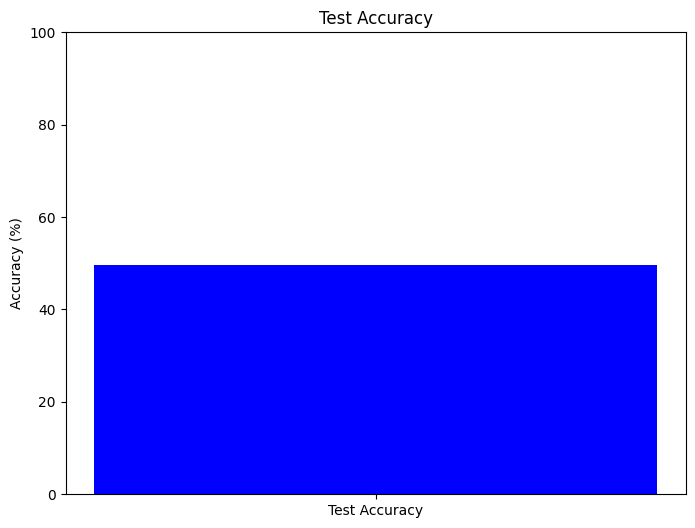

In [20]:
plt.figure(figsize=(8, 6))
plt.bar(["Test Accuracy"], [accuracy * 100], color='blue')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.ylim(0, 100)
plt.show()


In [21]:
model = EEGAutoencoderClassifier(num_classes).to(device)
dummy_input = torch.randn(1, 64 * 795).to(device)
output = model(dummy_input)
graph = make_dot(output, params=dict(model.named_parameters()))

#Save the graph
#graph.render(filename='model_graph', format='png')
# Display the graph
graph.view()

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 128])